In [ ]:
# Reference: Greg Hogg (YT) - https://www.youtube.com/watch?v=q_HS4s1L8UI&ab_channel=GregHogg

In [ ]:
%pip install yfinance pandas matplotlib numpy

In [ ]:
%pip install torch sklearn

In [38]:
import yfinance as yf
import torch 

data = yf.Ticker("AMZN").history(period="max")
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,1443120000,0.0,0.0
1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0
1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,122136000,0.0,0.0
1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,109344000,0.0,0.0
1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,377064000,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-27 00:00:00-05:00,225.600006,226.029999,220.899994,223.750000,27367100,0.0,0.0
2024-12-30 00:00:00-05:00,220.059998,223.000000,218.429993,221.300003,28321200,0.0,0.0
2024-12-31 00:00:00-05:00,222.970001,223.229996,218.940002,219.389999,24819700,0.0,0.0


In [39]:
from copy import deepcopy

def prepare_dataframe_for_lstm(dataframe, n):
    df = deepcopy(dataframe)
    
    for i in range(1, n+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    # Drop all rows with 'na' elements (First n dates)
    df.dropna(inplace=True)
    
    return df

# Pass in stock dataframe with only 'Close' column
n = 7
shifted_df = prepare_dataframe_for_lstm(data[['Close']], 7)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27 00:00:00-04:00,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28 00:00:00-04:00,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29 00:00:00-04:00,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30 00:00:00-04:00,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02 00:00:00-04:00,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2024-12-27 00:00:00-05:00,223.750000,227.050003,229.050003,225.059998,224.919998,223.289993,220.520004,231.149994
2024-12-30 00:00:00-05:00,221.300003,223.750000,227.050003,229.050003,225.059998,224.919998,223.289993,220.520004
2024-12-31 00:00:00-05:00,219.389999,221.300003,223.750000,227.050003,229.050003,225.059998,224.919998,223.289993


In [40]:
# Convert dataframe to numpy array for training
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[7.91670009e-02, 7.50000030e-02, 6.97920024e-02, ...,
        8.54170024e-02, 8.64579976e-02, 9.79169980e-02],
       [7.65630007e-02, 7.91670009e-02, 7.50000030e-02, ...,
        8.17710012e-02, 8.54170024e-02, 8.64579976e-02],
       [7.52599984e-02, 7.65630007e-02, 7.91670009e-02, ...,
        7.13540018e-02, 8.17710012e-02, 8.54170024e-02],
       ...,
       [2.19389999e+02, 2.21300003e+02, 2.23750000e+02, ...,
        2.25059998e+02, 2.24919998e+02, 2.23289993e+02],
       [2.20220001e+02, 2.19389999e+02, 2.21300003e+02, ...,
        2.29050003e+02, 2.25059998e+02, 2.24919998e+02],
       [2.24190002e+02, 2.20220001e+02, 2.19389999e+02, ...,
        2.27050003e+02, 2.29050003e+02, 2.25059998e+02]])

In [41]:
from sklearn.preprocessing import MinMaxScaler

# Normalizing the data using sklearn's MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99992842, -0.99996421, -1.        , ..., -0.9998658 ,
        -0.99985686, -0.99975844],
       [-0.99995079, -0.99992842, -0.99995527, ..., -0.99989711,
        -0.9998658 , -0.99985686],
       [-0.99996198, -0.99995079, -0.99991948, ..., -0.99998658,
        -0.99989711, -0.9998658 ],
       ...,
       [ 0.88370659,  0.90011138,  0.92115447, ...,  0.93240584,
         0.9312034 ,  0.91720355],
       [ 0.89083537,  0.88370659,  0.90011183, ...,  0.96667537,
         0.93240584,  0.9312034 ],
       [ 0.92493325,  0.89083537,  0.88370711, ...,  0.94949768,
         0.96667537,  0.93240584]])

In [42]:
import numpy as np

x = shifted_df_as_np[:, 1:] # Previous closes as input
x = deepcopy(np.flip(x, axis=1)) # Flip x horizontally so older data is processed first
y = shifted_df_as_np[:, 0]  # Current close as output

x.shape, y.shape

((6948, 7), (6948,))

In [43]:
split_index = int(len(x) * 0.95)

split_index

6600

In [61]:
# Split data into training and tests splits

x_train = x[:split_index]
y_train = y[:split_index]

x_test = x[split_index:]
y_test = y[split_index:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6600, 7), (348, 7), (6600,), (348,))

In [62]:
# Reshape splits for TensorFlow processing

# Add third dimension to x splits for number of features per time step
# Add second dimension to y splits for number of target values per time step

x_train = x_train.reshape((-1, n, 1))
x_test = x_test.reshape((-1, n, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6600, 7, 1), (348, 7, 1), (6600, 1), (348, 1))

In [63]:
# Wrap numpy arrays in PyTorch tensors 

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([6600, 7, 1]),
 torch.Size([348, 7, 1]),
 torch.Size([6600, 1]),
 torch.Size([348, 1]))

In [47]:
from torch.utils.data import Dataset

# Create custom dataset from inherited PyTorch Dataset class for our data

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

# Create our training and testing datasets 
train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)

In [48]:
from torch.utils.data import DataLoader

batch_size = 16

# Create our training and testing DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [49]:
import torch.nn as nn

# Custom LSTM neural network class 
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [54]:
def train_one_epoch(model, epoch, train_loader, loss_function, optimizer):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [55]:
def validate_one_epoch(model, test_loader):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [56]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(model, epoch, train_loader, loss_function, optimizer)
    validate_one_epoch(model, test_loader)

Epoch: 1
Batch 100, Loss: 0.240
Batch 200, Loss: 0.090
Batch 300, Loss: 0.032
Batch 400, Loss: 0.006

Val Loss: 0.117
***************************************************

Epoch: 2
Batch 100, Loss: 0.004
Batch 200, Loss: 0.004
Batch 300, Loss: 0.003
Batch 400, Loss: 0.003

Val Loss: 0.061
***************************************************

Epoch: 3
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002
Batch 400, Loss: 0.001

Val Loss: 0.042
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001

Val Loss: 0.028
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.000

Val Loss: 0.019
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000

Val Loss: 0.015
***************************

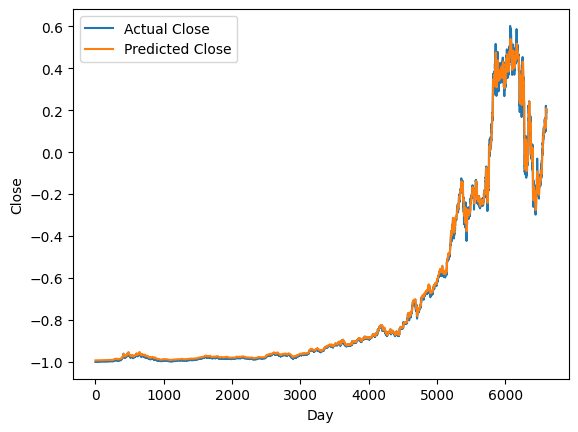

In [65]:
import matplotlib.pyplot as plt 

with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [66]:
train_predictions = predicted.flatten()

dummies = np.zeros((x_train.shape[0], n+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = deepcopy(dummies[:, 0])
train_predictions

array([  0.93701017,   0.93666319,   0.93630232, ..., 139.88895235,
       140.83794843, 140.3120824 ])

In [67]:
dummies = np.zeros((x_train.shape[0], n+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = deepcopy(dummies[:, 0])
new_y_train

array([7.91676298e-02, 7.65652259e-02, 7.52605541e-02, ...,
       1.40570007e+02, 1.37669999e+02, 1.35070008e+02])

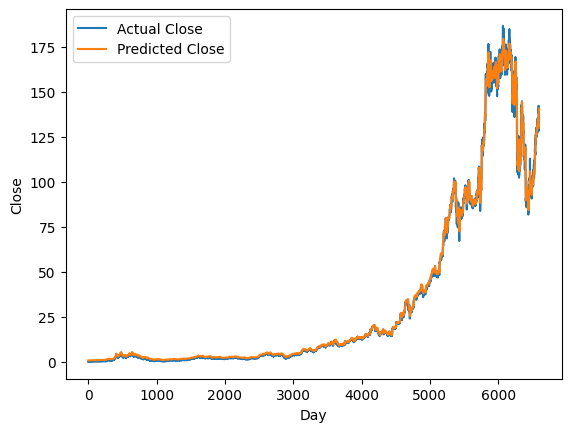

In [68]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [69]:
test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((x_test.shape[0], n+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = deepcopy(dummies[:, 0])
test_predictions

array([138.99505783, 137.75213585, 136.66902922, 136.2841441 ,
       135.89094168, 135.91066097, 134.92194874, 134.67277377,
       134.52759433, 134.98218918, 135.33813905, 136.51218408,
       137.41120706, 137.92477585, 137.6586922 , 138.20244888,
       138.6969542 , 140.51715877, 141.25219561, 142.82975898,
       144.04436681, 143.70056496, 143.17655879, 142.07320199,
       140.33979974, 137.26789094, 134.7149223 , 133.52968694,
       131.20493524, 129.43558858, 128.25493692, 127.84668567,
       128.50022563, 127.52393207, 127.39273968, 127.20114724,
       127.66459027, 128.12120112, 128.78875242, 129.9573324 ,
       131.14542346, 131.14505913, 131.99895643, 132.26802417,
       131.38668713, 130.73627005, 129.19062604, 128.43613363,
       128.62126517, 126.44649174, 124.23519445, 125.3057332 ,
       127.75595199, 129.78432458, 132.41290867, 134.66417889,
       136.70773911, 138.59228899, 140.60691048, 141.76060818,
       142.12234926, 143.11995824, 143.57558712, 144.81

In [70]:
dummies = np.zeros((x_test.shape[0], n+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = deepcopy(dummies[:, 0])
new_y_test

array([133.9799965 , 133.22000087, 134.67999283, 134.24999937,
       135.52000371, 131.83999639, 133.25999461, 133.1399995 ,
       134.9100037 , 135.07000817, 138.00999417, 138.11999432,
       137.27000409, 135.36000098, 137.85000532, 138.22999619,
       143.10000648, 141.22999537, 144.85000686, 144.72000117,
       140.39000011, 139.97999658, 137.63000503, 135.28999284,
       129.33000211, 129.11999506, 131.27000401, 125.98000304,
       125.98000304, 125.98000304, 127.12000255, 129.46000694,
       124.72000148, 126.99999963, 125.95999923, 127.95999868,
       128.25999426, 129.479996  , 131.83000143, 132.33000129,
       129.78999349, 132.55000331, 131.47000048, 128.13000505,
       128.39999404, 125.16999788, 126.55999733, 128.55999764,
       121.38999927, 119.56999964, 127.73999752, 132.71000604,
       133.08999692, 136.99999948, 138.07000734, 138.60000598,
       139.74000463, 142.71000676, 142.08000121, 140.60000543,
       143.55999698, 142.58999604, 145.800004  , 143.19

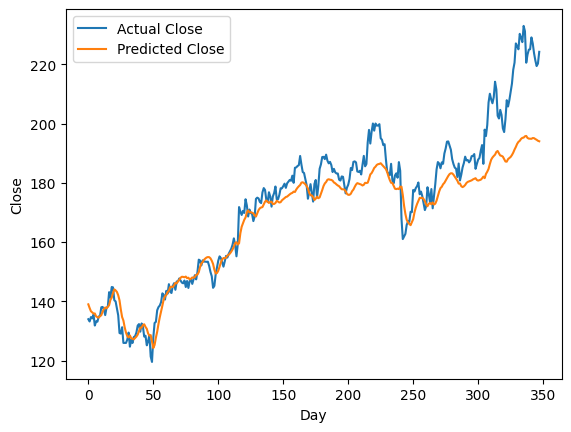

In [71]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
